
*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/Geom3.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/Geom3.msh successfully imported. 
Assign a material to a physical group.
*************************************************************
WARNING. Plese provide a elem_group_series for split mesh in grops.
WARNING. Plese provide a elem_group_series for split mesh in grops.
Extract interface node from sub_2 and sub_1
Interface nodes from sub_1 and sub_2 already extracted


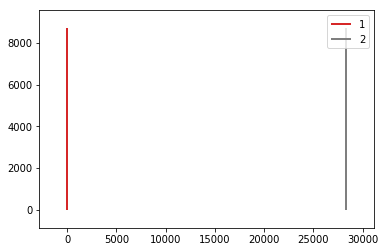

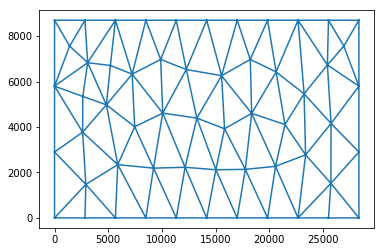

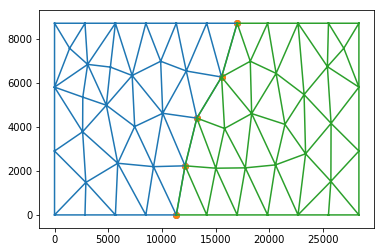

In [13]:
import sys 
import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy

msh_dict = {}
msh_dict[0] = amfe.amfe_dir('meshes/test_meshes/Geom3.msh')
msh_dict[1] = amfe.amfe_dir('meshes/test_meshes/simple_2.msh')
msh_dict[2] = mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_pressure_corner.msh')
msh_dict[3] = mshfile = amfe.amfe_dir('meshes/test_meshes/geo_hole_quad_part_4.msh')
msh_dict[4] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')

domain_id = {}
domain_id[0] = 3
domain_id[1] = 3
domain_id[2] = 11
domain_id[3] = 8
domain_id[4] = 3

# select mesh to be plotted
mesh_id = 0
mshfile = msh_dict[mesh_id]

m = amfe.Mesh()
m.import_msh(mshfile)


# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)


# splitting physical grops

m.split_in_groups()

# plotting boundary elements
amfe.plot_boundary_1d(m)



# plotting mesh
amfe.plot_submesh(m.groups[domain_id[mesh_id]])


# setting boundary condition
# selecting subdomain for boundary condition
sub_dir = m.get_submesh('physical',1)
sub_neu = m.get_submesh('physical',2)

value = 5.0E9
neu = amfe.boundary.Boundary(sub_neu,value,'normal')
diri = amfe.boundary.Boundary(sub_dir,0,'xy','dirichlet')


# setting main domain for FE calculation
domain = m.set_domain('phys_group', domain_id[mesh_id])
domain.set_material(my_material)
domain.append_bondary_condition(neu)
domain.append_bondary_condition(diri)
domain.split_in_partitions()
amfe.plot_domain(domain)

plt.show()

In [14]:
sub1 = domain.groups[1]
sub1.interface_nodes_dict

{2: [4, 5, 6, 7, 8]}

In [15]:
sub1 = amfe.feti_solver.FETIsubdomain(domain.groups[1])
sub2 = amfe.feti_solver.FETIsubdomain(domain.groups[2])

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 43 elements and 62 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 43 elements and 62 dofs.
Time taken for preallocation: 0.00 seconds.


In [16]:
K1, f1 = sub1.assemble_k_and_f()
K1, f1 = sub1.insert_dirichlet_boundary_cond(K1,f1)

K1 = K1.todense()
K, fext1 = sub1.assemble_k_and_f_neumann()
B1_dict = sub1.assemble_interface_boolean_matrix()
M1 = sub1.assemble_m().todense()
M1, fg = sub1.insert_dirichlet_boundary_cond(M1,f1)


K2, f = sub2.assemble_k_and_f()
K2 = K2.todense()
K, fext2 = sub2.assemble_k_and_f_neumann()

B2_dict = sub2.assemble_interface_boolean_matrix()
M2 = sub2.assemble_m().todense()

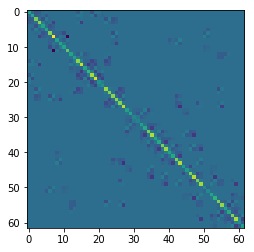

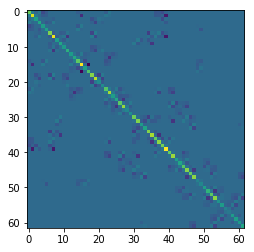

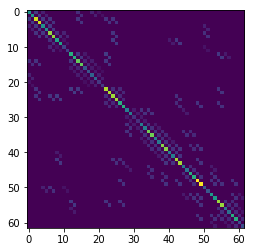

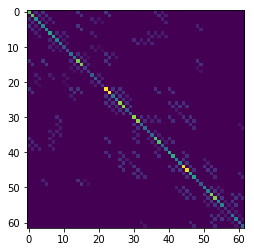

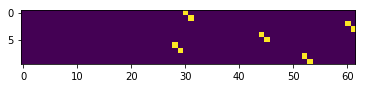

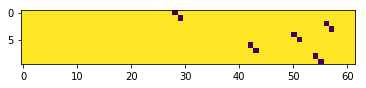

In [17]:
plt.imshow(K1, interpolation='nearest')
plt.show()

plt.imshow(K2, interpolation='nearest')
plt.show()

plt.imshow(M1, interpolation='nearest')
plt.show()

plt.imshow(M2, interpolation='nearest')
plt.show()

B1 = B1_dict[1,2].todense()
B2 = B2_dict[2,1].todense()

plt.imshow(B1, interpolation='nearest')
plt.show()

plt.imshow(B2, interpolation='nearest')
plt.show()

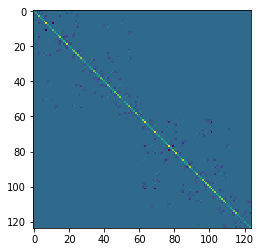

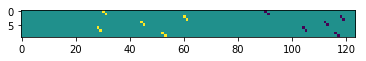

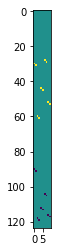

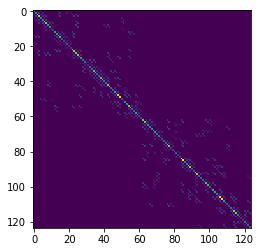

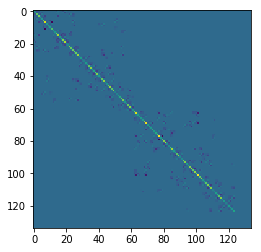

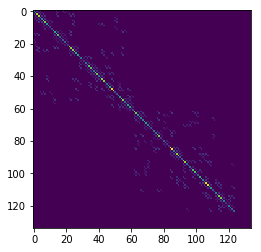

In [18]:
# Assemble the block subdomain matrix
n1 = K1.shape[0]
n2 = K2.shape[0]
nlambda = B1.shape[0]
u_dof = n1 + n2
total_dof = u_dof + nlambda


B = np.hstack((B1,1.0*B2))
Kd = scipy.linalg.block_diag(K1,K2)
Md = scipy.linalg.block_diag(M1,M2)

Zero_block = np.zeros([nlambda,nlambda])

plt.imshow(Kd, interpolation='nearest')
plt.show()

plt.imshow(B, interpolation='nearest')
plt.show()

plt.imshow(B.T, interpolation='nearest')
plt.show()

plt.imshow(Md, interpolation='nearest')
plt.show()

D1 = np.hstack((Kd,B.T))
D2 = np.hstack((B,Zero_block))
D = np.vstack((D1,D2))

A1 = np.hstack((Md, 0.0*B.T))
A2 = np.hstack((0.0*B,Zero_block))
A = np.vstack((A1,A2))

fd = np.hstack((fext1,fext2,np.zeros(nlambda)))

plt.imshow(D, interpolation='nearest')
plt.show()

plt.imshow(A, interpolation='nearest')
plt.show()

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# Solving a static problem
b = np.hstack((fext1,fext2,np.zeros(nlambda)))

x = scipy.linalg.solve(D,b)

connectivity = sub1.mesh.connectivity
nodes = sub1.mesh.nodes

connectivity2 = sub2.mesh.connectivity
nodes2 = sub2.mesh.nodes

def plot_static(scale):
    tri, ax = amfe.plotDeformMesh(connectivity,nodes,x[:n1],scale) 
    tri, ax = amfe.plotDeformMesh(connectivity2,nodes2,x[n1:(n1+n2)],scale,ax) 
    plt.show()
    
interact(plot_static,mode=(0,10,1),scale=(0,10,1))  

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\Lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5110281590178549e-22 / 1.1102230246251565e-16
  RuntimeWarning)


A Jupyter Widget

<function __main__.plot_static>

In [20]:
nlambda

10

In [21]:
K1, f1 = sub1.assemble_k_and_f()
K1 = K1.todense()
K, fext1 = sub1.assemble_k_and_f_neumann()
B1_dict = sub1.assemble_interface_boolean_matrix()
M1 = sub1.assemble_m().todense()



K2, f = sub2.assemble_k_and_f()
K2 = K2.todense()
K, fext2 = sub2.assemble_k_and_f_neumann()

B2_dict = sub2.assemble_interface_boolean_matrix()
M2 = sub2.assemble_m().todense()

Kd = scipy.linalg.block_diag(K1,K2)
Md = scipy.linalg.block_diag(M1,M2)

Zero_block = np.zeros([nlambda,nlambda])


D1 = np.hstack((Kd,B.T))
D2 = np.hstack((B,Zero_block))
D = np.vstack((D1,D2))

A1 = np.hstack((Md, 0.0*B.T))
A2 = np.hstack((0.0*B,Zero_block))
A = np.vstack((A1,A2))

w, V = scipy.linalg.eig(D,A)

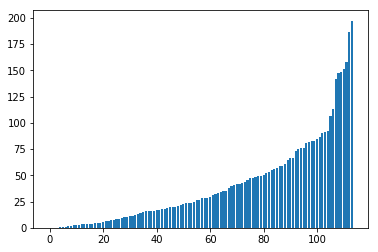

In [25]:
w = np.real(w)
V = np.real(V)

w_id = w.argsort(-1)
w= w[w_id]
V = V[:,w_id]

s= 10.0E6
for i,wi in enumerate(w):
    V[:,i] = s*wi*V[:,i]/np.linalg.norm(V[:,i])

plt.bar(np.arange(total_dof),w)
plt.show()

In [26]:
def plotmodes(mode,scale):
    tri, ax = amfe.plotDeformMesh(connectivity,nodes,V[0:n1,mode],scale) 
    tri, ax = amfe.plotDeformMesh(connectivity2,nodes2,V[n1:(n1+n2),mode],scale,ax) 
    plt.show()
    
interact(plotmodes,mode=(0,10,1),scale=(-100,100,2))    

A Jupyter Widget

<function __main__.plotmodes>